# CNNs, ResNets and LR-Scheduling

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Setup



In [3]:
!conda install -y gdown

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.11.17 |       hbcca054_0         151 KB  conda-forge
    certifi-2023.11.17         |     pyhd8ed1ab_0         155 KB  conda-forge
    filelock-3.13.1            |     pyhd8ed1ab_0          15 KB  conda-forge
    gdown-4.7.1                |     pyhd8ed1ab_0          19 KB  conda-forge
    ------------------------------------------------------------
                          

In [4]:
# Download setup.py from google drive
!gdown 1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk

Downloading...
From (uriginal): https://drive.google.com/uc?id=1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk
From (redirected): https://drive.google.com/uc?id=1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk&confirm=t&uuid=dedada1a-0b92-4a90-ae7d-d2911cfedb55
To: /kaggle/working/setup.py
100%|██████████████████████████████████████| 16.1k/16.1k [00:00<00:00, 49.3MB/s]


In [5]:
# import setup.py
import setup

## 2. Load dataset, create dataloader, etc.

We call the functions of `setup.py` to instantiate the train-, test- and validation datasets along with their dataloaders.

In [6]:
# We define device
device = setup.get_device()
device

device(type='cuda', index=0)

In [7]:
data_dir = 'data'
batch_size = 256

# We grab data, generate split and initialize data loaders
train_set, test_set = setup.grab_data(data_dir)
train_set, val_set = setup.generate_train_val_data_split(train_set, split_seed=42, val_frac=0.2)
train_loader, val_loader, test_loader = setup.init_data_loaders(train_set, val_set, test_set, batch_size)

100%|██████████| 170498071/170498071 [00:03<00:00, 52851007.14it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


In [8]:
# We define loss function
loss_fn = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

The first step to training a model is defining its architecture. We will define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

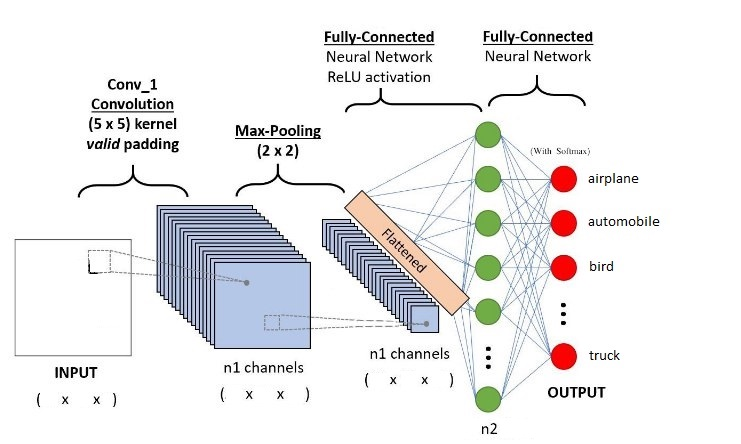

In [8]:
# We define model
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        # convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2,),
            nn.ReLU()
        )

        # Dummy forward pass to determine the output size after conv layers
        # for a batch size of 1 and an image size of 32x32x3
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)
            dummy_output = self.conv_layers(dummy_input)
            flattened_size = dummy_output.data.view(1, -1).size(1)
    
        # fully-connected/linear layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Linear(512, 10)   # 10 classes
        )
        
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [9]:
model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [10]:
!pip install torchsummary

In [11]:
from torchsummary import summary

# taking the input size as (3, 32, 32)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,432
         MaxPool2d-2           [-1, 32, 14, 14]               0
              ReLU-3           [-1, 32, 14, 14]               0
           Flatten-4                 [-1, 6272]               0
            Linear-5                  [-1, 512]       3,211,776
              ReLU-6                  [-1, 512]               0
            Linear-7                   [-1, 10]           5,130
Total params: 3,219,338
Trainable params: 3,219,338
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.34
Params size (MB): 12.28
Estimated Total Size (MB): 12.64
----------------------------------------------------------------


Now we will train the model for 10 epochs. Try lr=0.001 (can be changed to suit other design choices you make). After that plot the results of accuracy and loss.

Finished training after 119 seconds.


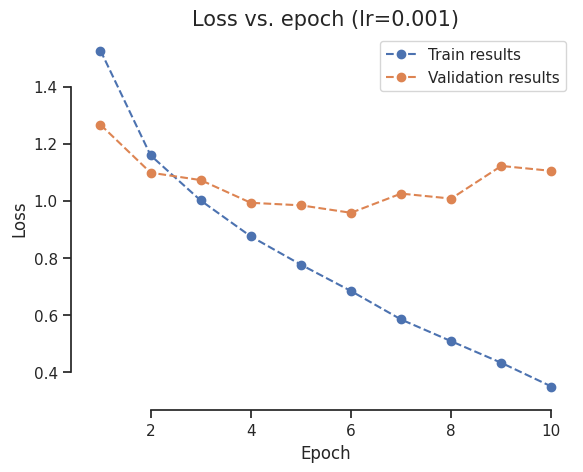

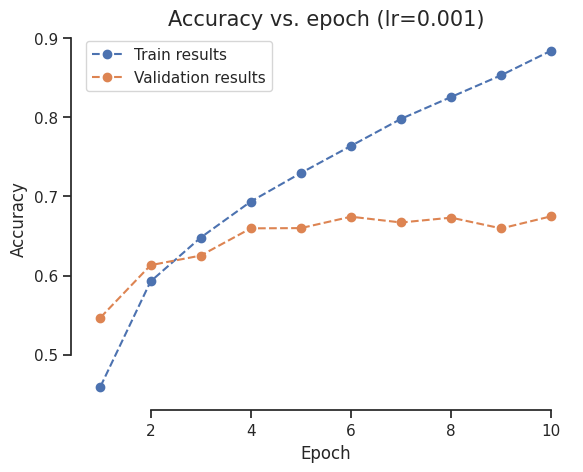

<Figure size 640x480 with 0 Axes>

In [12]:
# We train and plot for 10 epochs
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
n_epochs = 10
train_losses, val_losses, train_accs, val_accs, confusion_matrix = setup.run_training(model=model, optimizer=optimizer, loss_function=loss_fn, 
                                                                                      device=device, num_epochs=n_epochs, 
                                                                                      train_dataloader=train_loader, val_dataloader=val_loader, 
                                                                                      early_stopper=None, verbose=False)

setup.plot(f'Loss vs. epoch (lr={lr})', 'Loss', train_losses, val_losses,)
plt.tight_layout()
setup.plot(f'Accuracy vs. epoch (lr={lr})', 'Accuracy', train_accs, val_accs,)
plt.tight_layout()

Comparing with an MLP model, the CNN model outperforms the MLP after just 10 epochs of training, indicating its enhanced ability to capture spatial features in the data. While not optimal, the CNN's results are notably superior to those of the MLP, highlighting the effectiveness of convolutional architectures in pattern recognition tasks.

**Below is the loss and accuracy plots of an MLP model**

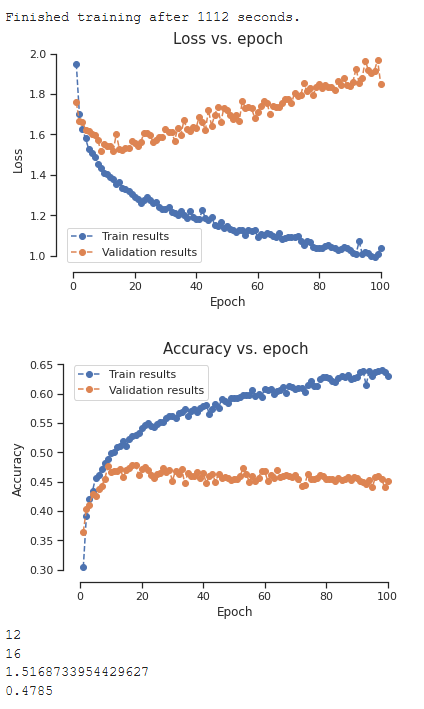

Now we will train longer (60 epochs), then plot again.

Finished training after 688 seconds.


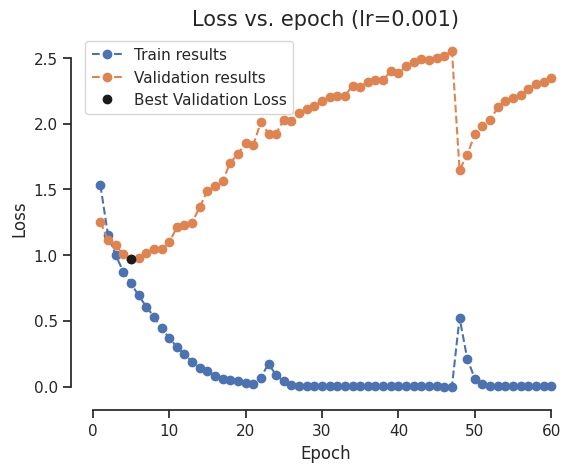

Best Validation Loss (overall): 0.9698505833745003 @ Epoch no. 5


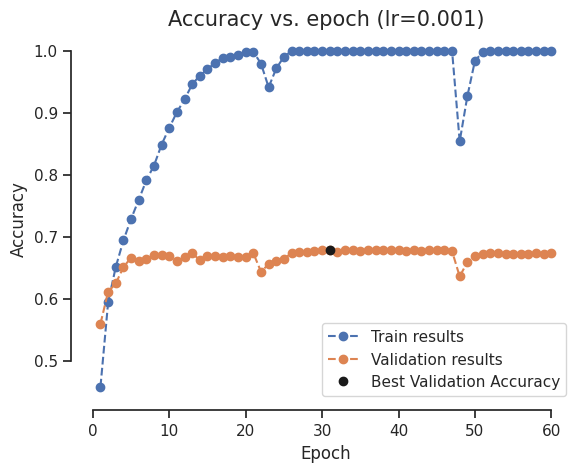

Best Validation Accuracy (overall): 0.6787 @ Epoch no. 31


<Figure size 640x480 with 0 Axes>

In [13]:
# We train and plot for 60 epochs
model = SimpleCNN()
model.to(device)
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
n_epochs = 60
# early_stopper = setup.EarlyStopper(patience=5)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = setup.run_training(model=model, optimizer=optimizer, loss_function=loss_fn, 
                                                                                      device=device, num_epochs=n_epochs, 
                                                                                      train_dataloader=train_loader, val_dataloader=val_loader, 
                                                                                      early_stopper=None, verbose=False)

best_val_loss,best_val_loss_epoch = np.min(val_losses), np.argmin(val_losses)+1
best_val_acc, best_val_acc_epoch = np.max(val_accs), np.argmax(val_accs)+1

setup.plot(f'Loss vs. epoch (lr={lr})', 'Loss', train_losses, val_losses,
          extra_pt=(best_val_loss_epoch, best_val_loss), 
           extra_pt_label='Best Validation Loss')
plt.tight_layout()
print(f"Best Validation Loss (overall): {best_val_loss} @ Epoch no. {best_val_loss_epoch}")
setup.plot(f'Accuracy vs. epoch (lr={lr})', 'Accuracy', train_accs, val_accs,
           extra_pt=(best_val_acc_epoch, best_val_acc), 
           extra_pt_label='Best Validation Accuracy')
plt.tight_layout()
print(f"Best Validation Accuracy (overall): {best_val_acc} @ Epoch no. {best_val_acc_epoch}")

- The model is not optimal due to overfitting, as evidenced by diverging training and validation losses and a plateauing validation accuracy. 
- Some of the possible improvements could include implementing early stopping, regularization techniques and learning rate adjustments (sudden spike in validation loss could indicate that the learning rate is too high).

## 4. CNN model with more convolutional layers

We will define the architecture using the following information:



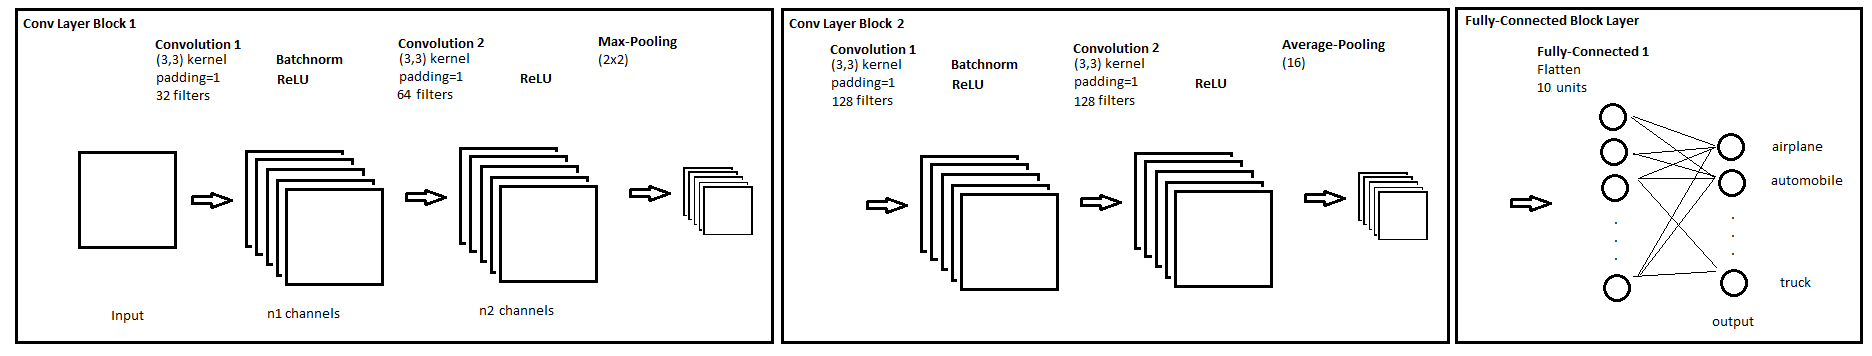

*   Convolutional layer 1: with 32 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 2: with 64 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Max pooling with kernel size of 2*2
*   Convolutional layer 3: with 128 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 4: with 128 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Average pooling with kernel size 16*16
*   Fully connected layer

In [14]:
#We define model 2
class DeepCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # convolutional layers
        self.conv_layers = nn.Sequential(
            # Conv. layer 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Conv. layer 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,),
            
            # Conv. layer 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        
            # Conv. Layer 4
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=16)
        )

        # Dummy forward pass to determine the output size after conv layers
        # for a batch size of 1 and an image size of 32x32x3
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)
            dummy_output = self.conv_layers(dummy_input)
            flattened_size = dummy_output.data.view(1, -1).size(1)
    
        # fully-connected/linear layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
#             nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Linear(flattened_size, 10)   # 10 classes
        )
        
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [15]:
model2 = DeepCNN()
model2.to(device)
summary(model2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
             ReLU-11          [-1, 128, 16, 16]               0
        AvgPool2d-12            [-1, 128, 1, 1]               0
          Flatten-13                  [-1, 128]               0
             ReLU-14                  [

Now we will train the new net (30 epochs, try lr=0.1 or change as necessary), plot the results, and compare the results to the 1-layer CNN. Finally we will explain why we observe these results

Finished training after 464 seconds.


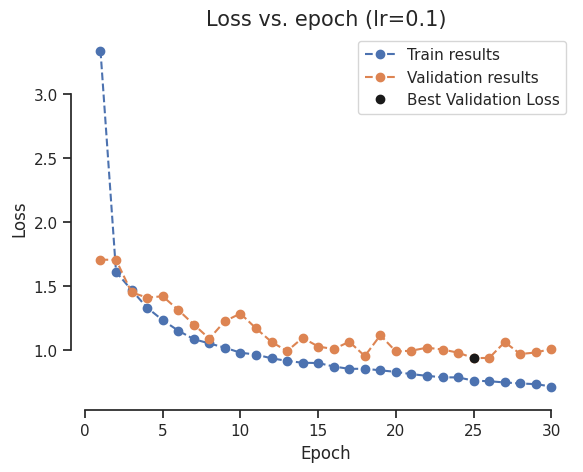

Best Validation Loss (overall): 0.9396685898303986 @ Epoch no. 25


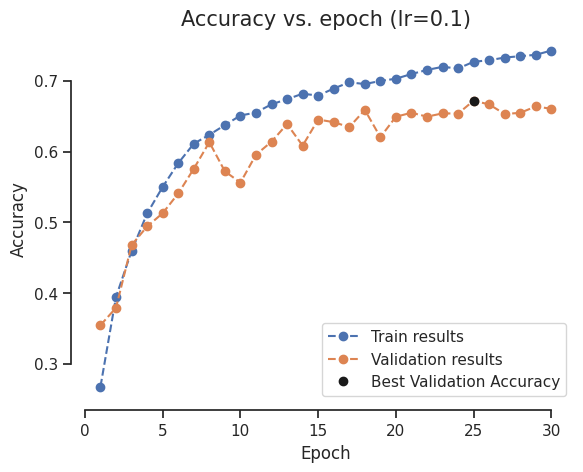

Best Validation Accuracy (overall): 0.6719 @ Epoch no. 25


<Figure size 640x480 with 0 Axes>

In [16]:
# We train and plot for 30 epochs
lr = 0.1
optimizer = optim.Adam(model2.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 30
# early_stopper = setup.EarlyStopper(patience=10)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = setup.run_training(model=model2, optimizer=optimizer, loss_function=loss_fn, 
                                                                                      device=device, num_epochs=n_epochs, 
                                                                                      train_dataloader=train_loader, val_dataloader=val_loader, 
                                                                                      early_stopper=None, verbose=False)

best_val_loss,best_val_loss_epoch = np.min(val_losses), np.argmin(val_losses)+1
best_val_acc, best_val_acc_epoch = np.max(val_accs), np.argmax(val_accs)+1

setup.plot(f'Loss vs. epoch (lr={lr})', 'Loss', train_losses, val_losses,
          extra_pt=(best_val_loss_epoch, best_val_loss), 
           extra_pt_label='Best Validation Loss')
plt.tight_layout()
print(f"Best Validation Loss (overall): {best_val_loss} @ Epoch no. {best_val_loss_epoch}")
setup.plot(f'Accuracy vs. epoch (lr={lr})', 'Accuracy', train_accs, val_accs,
           extra_pt=(best_val_acc_epoch, best_val_acc), 
           extra_pt_label='Best Validation Accuracy')
plt.tight_layout()
print(f"Best Validation Accuracy (overall): {best_val_acc} @ Epoch no. {best_val_acc_epoch}")

The more complex CNN architecture shows improved performance and generalization compared to the earlier 1-layer CNN which can likely be attributed to its increased representational capacity, regularization effects from batch normalization, and effective pooling strategies, all contributing to a model that can capture complex patterns more effectively without overfitting.

## 5. ResNet architecture


A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

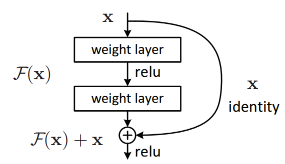
- Skip connections solve two primary problems in DNNs:
    1. **Vanishing Gradients**: As networks get deeper, gradients can become smaller during backpropagation, making it difficult to train the network effectively. Skip connections allow gradients to flow directly through the network, mitigating the vanishing gradient problem by providing an alternative shortcut path for the gradient during the optimization process.
    2. **Degradation Problem**: In very deep networks, adding more layers can lead to higher training error, even though these layers should, in theory, allow for at least the performance of the shallower model. Skip connections help to prevent this performance degradation by enabling the direct learning of identity mappings, thus allowing additional layers to learn residual mappings, which are often easier to optimize.
    
- A residual network is called "residual" because, instead of learning direct mappings from input to output, the layers in these networks learn residual functions. That is, they learn the difference (or residual) between the input and the output, which is supposed to be easier to optimize and allows the network to effectively learn the identity function where needed. The architecture explicitly allows the network to perform learning on the residuals (the differences) rather than on the full output, which can be more efficient and effective, particularly in deep networks.

Now we will write a class **ResidualBlock(nn.Module)** where we define the blocks used in the ResNet. After that, we will write a class **ResNet(nn.Module)** where we define the model. 
Finally we will train the model and plot results, and train another model by disable residual connections and compare performance

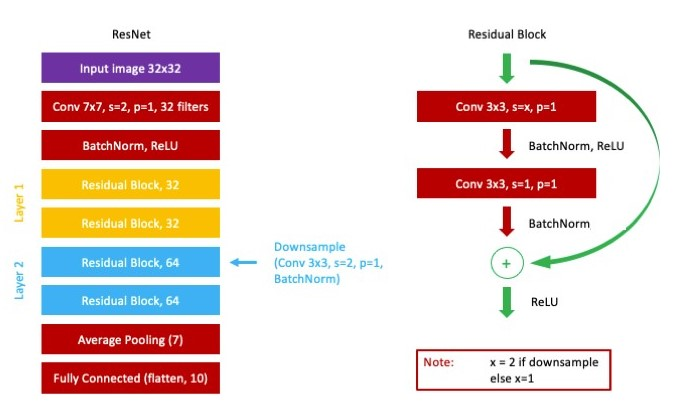

In [9]:
# We write a class ResidualBlock(nn.Module) where we define the blocks used in the ResNet
class ResidualBlock(nn.Module):
    """
    A ResNet residual block with two convolutional layers.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer.
        bn1 (nn.BatchNorm2d): Batch normalization after the first convolution.
        conv2 (nn.Conv2d): Second convolutional layer.
        bn2 (nn.BatchNorm2d): Batch normalization after the second convolution.
        downsample (nn.Module): Downsample layer if input and output dimensions differ.

    Methods:
        forward(x): Passes the input through the residual block and returns the output.
    """
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        """
        Forward pass for the ResidualBlock.

        Parameters:
            x (Tensor): The input tensor with shape (N, C, H, W).
        
        Returns:
            Tensor: Output tensor after adding the block input to the block output.
        """
        identity = x
        residual = self.relu(self.bn1(self.conv1(x)))
        residual = self.bn2(self.conv2(residual))
        
        if self.downsample:
            identity = self.downsample(identity)
            
        out = residual + identity
        out = self.relu(out)
        return out

In [10]:
# We write a class ResNet(nn.Module) where we define the model
class ResNet(nn.Module):
    """
    ResNet model constructor for image classification with residual blocks.

    Attributes:
        conv (nn.Conv2d): Initial convolutional layer.
        bn (nn.BatchNorm2d): Initial batch normalization layer.
        layer1 (nn.Sequential): First set of residual blocks.
        layer2 (nn.Sequential): Second set of residual blocks with increased channels and downsampling.
        avg_pool (nn.AvgPool2d): Average pooling layer.
        fc (nn.Linear): Fully connected layer for classification.

    Methods:
        _make_layer(block, out_channels, blocks, stride): Constructs a layer of residual blocks.
        forward(x): Defines the forward pass of the model.
    """
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_channels = 32
        self.conv = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.layer1 = self._make_layer(block, 32, num_blocks[0])
        self.layer2 = self._make_layer(block, 64, num_blocks[1], 2)
        self.avg_pool = nn.AvgPool2d(7)
        self.fc = nn.Linear(64, num_classes)
    
    def _make_layer(self, block, out_channels, n_blocks, stride=1):
        """
        Constructs a sequential layer of residual blocks.

        Parameters:
            block (nn.Module): The residual block class.
            out_channels (int): Number of output channels for the blocks.
            blocks (int): Number of residual blocks in the layer.
            stride (int): Stride for downsampling, default is 1.

        Returns:
            nn.Sequential: The constructed layer of residual blocks.
        """
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, n_blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Forward pass for the ResNet.

        Parameters:
            x (Tensor): The input tensor with shape (N, C_in, H_in, W_in).

        Returns:
            Tensor: Output tensor with shape (N, num_classes) representing class scores.
        """
        x = self.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [11]:
resnet_model = ResNet(ResidualBlock, [2, 2])
resnet_model.to(device)
print(resnet_model)

ResNet(
  (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, 

In [37]:
summary(resnet_model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,704
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,216
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,216
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,216
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
           Conv2d-14           [-1, 32,

Finished training after 387 seconds.


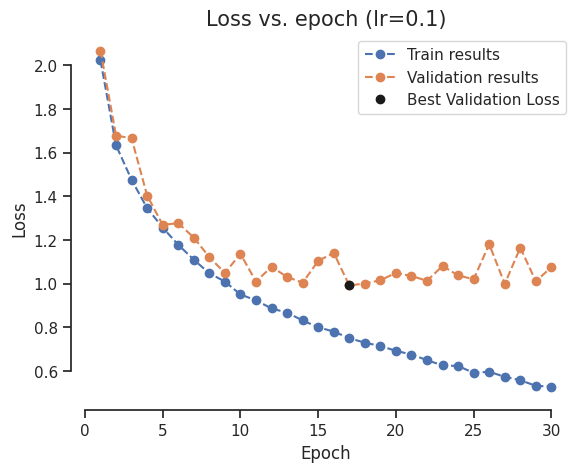

Best Validation Loss (overall): 0.9923654243350029 @ Epoch no. 17


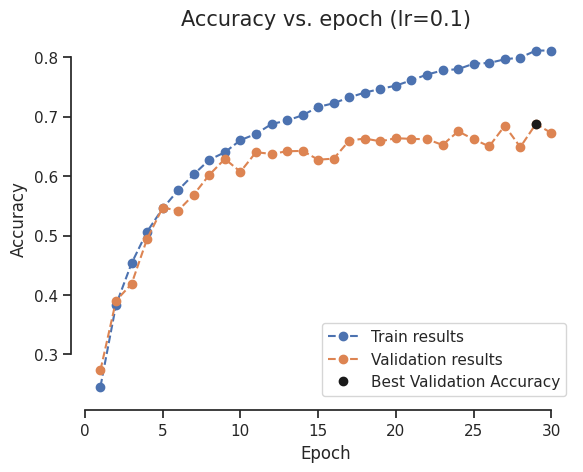

Best Validation Accuracy (overall): 0.6877 @ Epoch no. 29


<Figure size 640x480 with 0 Axes>

In [38]:
# We train ResNet and plot loss and accuracy for training and validation set.
lr = 0.1
optimizer = optim.Adam(resnet_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 30
# early_stopper = setup.EarlyStopper(patience=10)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = setup.run_training(model=resnet_model, optimizer=optimizer, loss_function=loss_fn, 
                                                                                      device=device, num_epochs=n_epochs, 
                                                                                      train_dataloader=train_loader, val_dataloader=val_loader, 
                                                                                      early_stopper=None, verbose=False)

best_val_loss,best_val_loss_epoch = np.min(val_losses), np.argmin(val_losses)+1
best_val_acc, best_val_acc_epoch = np.max(val_accs), np.argmax(val_accs)+1

setup.plot(f'Loss vs. epoch (lr={lr})', 'Loss', train_losses, val_losses,
          extra_pt=(best_val_loss_epoch, best_val_loss), 
           extra_pt_label='Best Validation Loss')
plt.tight_layout()
print(f"Best Validation Loss (overall): {best_val_loss} @ Epoch no. {best_val_loss_epoch}")
setup.plot(f'Accuracy vs. epoch (lr={lr})', 'Accuracy', train_accs, val_accs,
           extra_pt=(best_val_acc_epoch, best_val_acc), 
           extra_pt_label='Best Validation Accuracy')
plt.tight_layout()
print(f"Best Validation Accuracy (overall): {best_val_acc} @ Epoch no. {best_val_acc_epoch}")

In [46]:
# Now we define another model by disabling all residual connections, and plot loss and accuracy curves for training and validation set.
class PlainBlock(nn.Module):
    """
    A block similar to ResNet's residual block but without the skip connection.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out


class PlainNet(nn.Module):
    """
    A network with architecture similar to ResNet but without residual connections.
    """
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_channels = 32
        self.conv = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.layer1 = self._make_layer(block, 32, num_blocks[0])
        self.layer2 = self._make_layer(block, 64, num_blocks[1], 2)
        self.avg_pool = nn.AvgPool2d(7)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, n_blocks, stride=1):
        layers = []
        for _ in range(n_blocks):
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
            stride = 1  # Only the first block will have the stride to downsample, subsequent blocks will have a stride of 1.

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

plain_model = PlainNet(PlainBlock, [2, 2])
plain_model.to(device)
summary(plain_model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,704
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,216
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,216
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
       PlainBlock-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,216
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
           Conv2d-14           [-1, 32,

Finished training after 378 seconds.


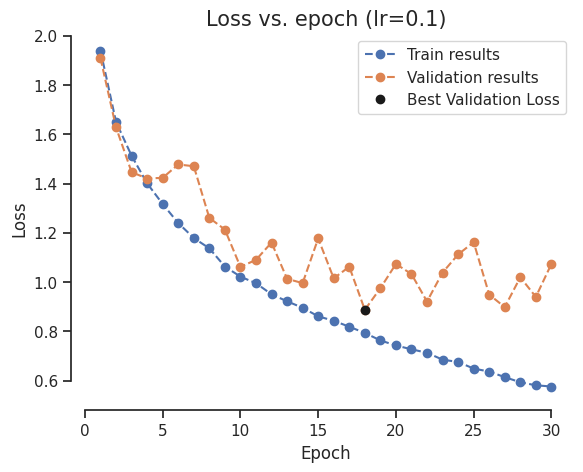

Best Validation Loss (overall): 0.8877324841916561 @ Epoch no. 18


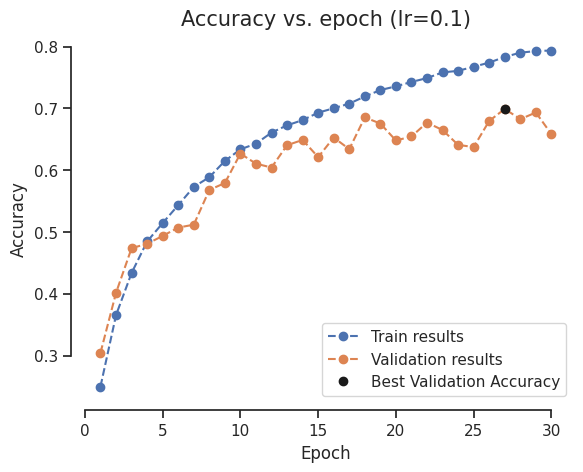

Best Validation Accuracy (overall): 0.6992 @ Epoch no. 27


<Figure size 640x480 with 0 Axes>

In [47]:
# We train ResNet and plot loss and accuracy for training and validation set.
lr = 0.1
optimizer = optim.Adam(plain_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 30
# early_stopper = setup.EarlyStopper(patience=10)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = setup.run_training(model=plain_model, optimizer=optimizer, loss_function=loss_fn, 
                                                                                      device=device, num_epochs=n_epochs, 
                                                                                      train_dataloader=train_loader, val_dataloader=val_loader, 
                                                                                      early_stopper=None, verbose=False)

best_val_loss,best_val_loss_epoch = np.min(val_losses), np.argmin(val_losses)+1
best_val_acc, best_val_acc_epoch = np.max(val_accs), np.argmax(val_accs)+1

setup.plot(f'Loss vs. epoch (lr={lr})', 'Loss', train_losses, val_losses,
          extra_pt=(best_val_loss_epoch, best_val_loss), 
           extra_pt_label='Best Validation Loss')
plt.tight_layout()
print(f"Best Validation Loss (overall): {best_val_loss} @ Epoch no. {best_val_loss_epoch}")
setup.plot(f'Accuracy vs. epoch (lr={lr})', 'Accuracy', train_accs, val_accs,
           extra_pt=(best_val_acc_epoch, best_val_acc), 
           extra_pt_label='Best Validation Accuracy')
plt.tight_layout()
print(f"Best Validation Accuracy (overall): {best_val_acc} @ Epoch no. {best_val_acc_epoch}")

In our case, the difference in performance between the two networks (with and without residual connections) does **not** seem to be too pronounced. The benefit of using ResNet architecture becomes most visible in deeper networks where degradation and vanishing gradient problems are more pronounced, which can hinder training and generalization. Residual connections mitigate these issues by improving gradient flow throughout the network, which is less of a factor in shallower networks.

In deeper networks, residual blocks can actually reduce training time by easing the optimization process. They allow for better gradient propagation, which often results in faster convergence. This means that, despite the potential increase in the number of operations due to additional paths, the network may require fewer epochs to reach optimal performance.

Since the CNNs we trained in the previous section were relatively shallower, their training times were usually shorter as compared to our ResNet architecture. However, the deeper one we trained took longer training time (\~464s) than the ResNet network (\~387s).

## 6. Explore Learning Rate Scheduling



Now we will change run_training and extend it to use scheduler for learning rate. We will use StepLR, as specified in (https://pytorch.org/docs/stable/optim.html)

As we will see, with a `gamma` of 0.1 and a `step_size` of 1, the learning rate is reduced to 10% of its previous value after every epoch. This is a very aggressive reduction, leading to a rapid decrease in the learning rate with each subsequent epoch.

The learning curves with `gamma=0.1` show that after a sharp initial decrease, the validation loss starts to oscillate, and the validation accuracy reaches a plateau early in the training. This behavior might indicate that the learning rate becomes too small too quickly, hindering the network's ability to converge to a better solution and leading to suboptimal performance.

With `gamma=0.9` and `step_size` of 1, the learning rate decreases to 90% of its value every epoch. This is a more conservative approach that reduces the learning rate gradually.

The learning curves with `gamma=0.9` exhibit smoother and more consistent progress in both training and validation metrics. The validation loss decreases steadily, and the validation accuracy improves over time without significant fluctuations. This suggests that the learning rate remains in a suitable range for the network to learn effectively throughout the training process.
  
A balanced synergy between step_size and gamma is crucial to ensure the learning rate is reduced optimally. The right combination allows for initial rapid learning while still being able to fine-tune the network's weights in later epochs. 

This experiment suggests that a gamma of 0.9 with a step_size of 1 provides a more stable and effective learning rate schedule compared to a gamma of 0.1, as it leads to better convergence behavior and improved performance.

In [12]:
# We change run_training to introduce the scheduler
from setup import train, validate 

def run_training(model, optimizer, loss_function, scheduler, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        # Update the learning rate scheduler
        scheduler.step()
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.early_stop:
                model = early_stopper.load_checkpoint(model)
                print('early stopping')
                break
            # END OF YOUR CODE #
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix

Finished training after 129 seconds.


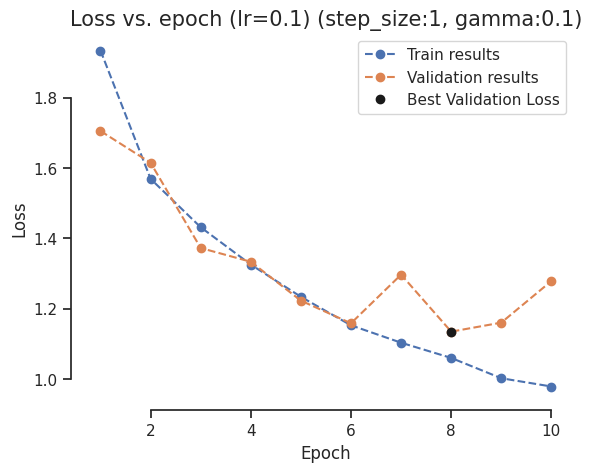

Best Validation Loss (overall): 1.1346034973859787 @ Epoch no. 8


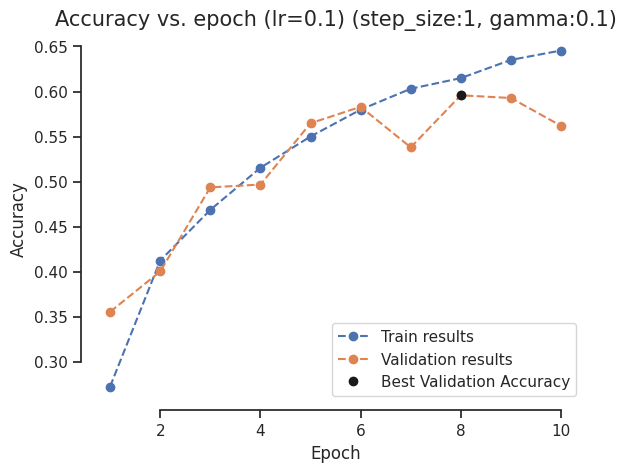

Best Validation Accuracy (overall): 0.5958 @ Epoch no. 8


<Figure size 640x480 with 0 Axes>

In [55]:
# We train and plot with step size 1, gamma 0.1

resnet_model2 = ResNet(ResidualBlock, [2, 2])
resnet_model2.to(device)

initial_lr = 0.1
optimizer = optim.Adam(resnet_model2.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()
n_epochs = 10
# early_stopper = setup.EarlyStopper(patience=10)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = setup.run_training(model=resnet_model2, optimizer=optimizer, loss_function=loss_fn, 
                                                                                      device=device, num_epochs=n_epochs, 
                                                                                      train_dataloader=train_loader, val_dataloader=val_loader, 
                                                                                      early_stopper=None, verbose=False)

best_val_loss,best_val_loss_epoch = np.min(val_losses), np.argmin(val_losses)+1
best_val_acc, best_val_acc_epoch = np.max(val_accs), np.argmax(val_accs)+1

setup.plot(f'Loss vs. epoch (lr={lr}) (step_size:1, gamma:0.1)', 'Loss', train_losses, val_losses,
          extra_pt=(best_val_loss_epoch, best_val_loss), 
           extra_pt_label='Best Validation Loss')
plt.tight_layout()
print(f"Best Validation Loss (overall): {best_val_loss} @ Epoch no. {best_val_loss_epoch}")
setup.plot(f'Accuracy vs. epoch (lr={lr}) (step_size:1, gamma:0.1)', 'Accuracy', train_accs, val_accs,
           extra_pt=(best_val_acc_epoch, best_val_acc), 
           extra_pt_label='Best Validation Accuracy')
plt.tight_layout()
print(f"Best Validation Accuracy (overall): {best_val_acc} @ Epoch no. {best_val_acc_epoch}")

Finished training after 130 seconds.


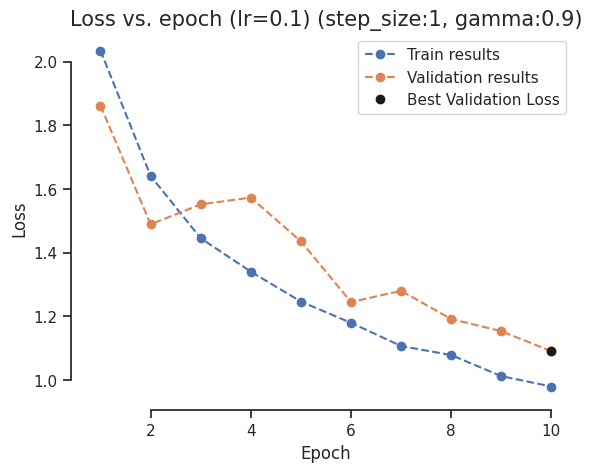

Best Validation Loss (overall): 1.090257954597473 @ Epoch no. 10


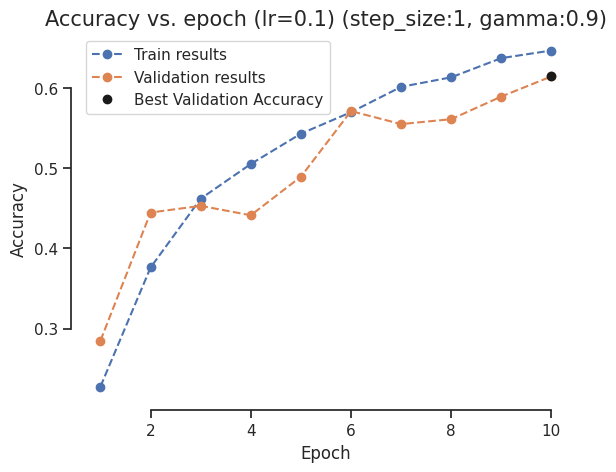

Best Validation Accuracy (overall): 0.6144 @ Epoch no. 10


<Figure size 640x480 with 0 Axes>

In [56]:
# We train and plot with step size 1, gamma 0.9, 10 epochs

resnet_model3 = ResNet(ResidualBlock, [2, 2])
resnet_model3.to(device)

initial_lr = 0.1
optimizer = optim.Adam(resnet_model3.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

loss_fn = nn.CrossEntropyLoss()
n_epochs = 10
# early_stopper = setup.EarlyStopper(patience=10)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = setup.run_training(model=resnet_model3, optimizer=optimizer, loss_function=loss_fn, 
                                                                                      device=device, num_epochs=n_epochs, 
                                                                                      train_dataloader=train_loader, val_dataloader=val_loader, 
                                                                                      early_stopper=None, verbose=False)

best_val_loss,best_val_loss_epoch = np.min(val_losses), np.argmin(val_losses)+1
best_val_acc, best_val_acc_epoch = np.max(val_accs), np.argmax(val_accs)+1

setup.plot(f'Loss vs. epoch (lr={lr}) (step_size:1, gamma:0.9)', 'Loss', train_losses, val_losses,
          extra_pt=(best_val_loss_epoch, best_val_loss), 
           extra_pt_label='Best Validation Loss')
plt.tight_layout()
print(f"Best Validation Loss (overall): {best_val_loss} @ Epoch no. {best_val_loss_epoch}")
setup.plot(f'Accuracy vs. epoch (lr={lr}) (step_size:1, gamma:0.9)', 'Accuracy', train_accs, val_accs,
           extra_pt=(best_val_acc_epoch, best_val_acc), 
           extra_pt_label='Best Validation Accuracy')
plt.tight_layout()
print(f"Best Validation Accuracy (overall): {best_val_acc} @ Epoch no. {best_val_acc_epoch}")

Now we will use step size 15.

With this larger step size and a low gamma (0.1), the network experiences a very sharp decrease in the learning rate at the 15th epoch, which can impede further learning.

With the same step size but a higher gamma (0.9), the decrease is less dramatic, allowing for more gradual learning and potentially better fine-tuning.

Performance appears to be better sustained with `gamma=0.9`, which indicates that while a large step size can be useful for maintaining a steady learning rate, the rate at which this learning rate decreases (controlled by gamma) is crucial to ensure continued performance improvement.

An increased step size delays the learning rate changes, which can be both beneficial and detrimental:

Beneficial if the initial learning rate is appropriate, as it allows the network to learn for more epochs before making any adjustments.

Detrimental if the learning rate needs to be adjusted sooner to continue the optimization process effectively, especially if the network has almost converged and needs finer updates.

Finished training after 385 seconds.


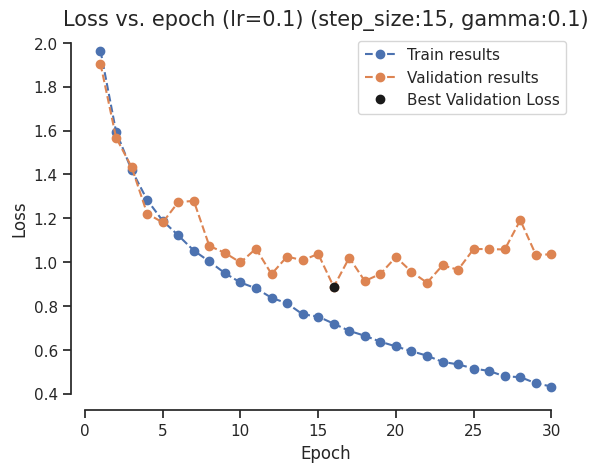

Best Validation Loss (overall): 0.8875453159213066 @ Epoch no. 16


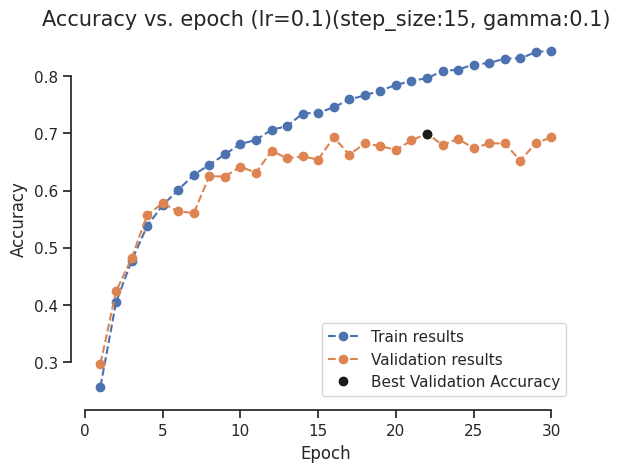

Best Validation Accuracy (overall): 0.6996 @ Epoch no. 22


<Figure size 640x480 with 0 Axes>

In [14]:
# We train and plot with step size 15, gamma 0.1, 30 epochs.



resnet_model4 = ResNet(ResidualBlock, [2, 2])
resnet_model4.to(device)

initial_lr = 0.1
optimizer = optim.Adam(resnet_model4.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()
n_epochs = 30
# early_stopper = setup.EarlyStopper(patience=10)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = setup.run_training(model=resnet_model4, optimizer=optimizer, loss_function=loss_fn, 
                                                                                      device=device, num_epochs=n_epochs, 
                                                                                      train_dataloader=train_loader, val_dataloader=val_loader, 
                                                                                      early_stopper=None, verbose=False)

best_val_loss,best_val_loss_epoch = np.min(val_losses), np.argmin(val_losses)+1
best_val_acc, best_val_acc_epoch = np.max(val_accs), np.argmax(val_accs)+1

setup.plot(f'Loss vs. epoch (lr={initial_lr}) (step_size:15, gamma:0.1)', 'Loss', train_losses, val_losses,
          extra_pt=(best_val_loss_epoch, best_val_loss), 
           extra_pt_label='Best Validation Loss')
plt.tight_layout()
print(f"Best Validation Loss (overall): {best_val_loss} @ Epoch no. {best_val_loss_epoch}")
setup.plot(f'Accuracy vs. epoch (lr={initial_lr})(step_size:15, gamma:0.1)', 'Accuracy', train_accs, val_accs,
           extra_pt=(best_val_acc_epoch, best_val_acc), 
           extra_pt_label='Best Validation Accuracy')
plt.tight_layout()
print(f"Best Validation Accuracy (overall): {best_val_acc} @ Epoch no. {best_val_acc_epoch}")

Finished training after 383 seconds.


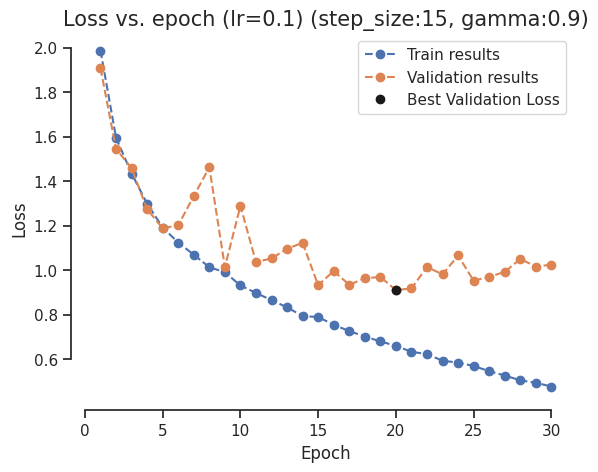

Best Validation Loss (overall): 0.911022287607193 @ Epoch no. 20


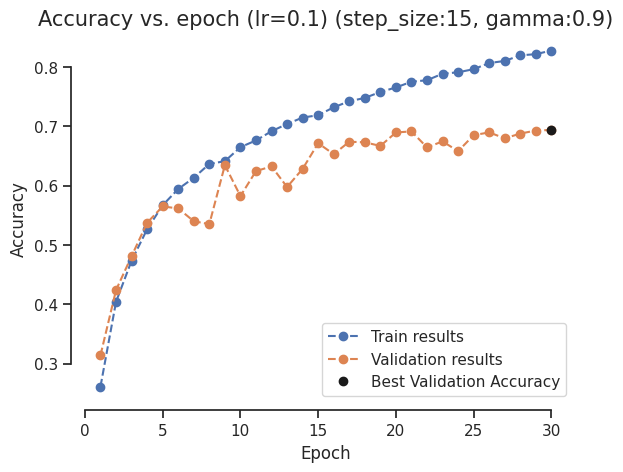

Best Validation Accuracy (overall): 0.6939 @ Epoch no. 30


<Figure size 640x480 with 0 Axes>

In [15]:
# We train and plot with step size 15, gamma 0.9, 30 epochs.

resnet_model5 = ResNet(ResidualBlock, [2, 2])
resnet_model5.to(device)

initial_lr = 0.1
optimizer = optim.Adam(resnet_model5.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.9)

loss_fn = nn.CrossEntropyLoss()
n_epochs = 30
# early_stopper = setup.EarlyStopper(patience=10)
train_losses, val_losses, train_accs, val_accs, confusion_matrix = setup.run_training(model=resnet_model5, optimizer=optimizer, loss_function=loss_fn, 
                                                                                      device=device, num_epochs=n_epochs, 
                                                                                      train_dataloader=train_loader, val_dataloader=val_loader, 
                                                                                      early_stopper=None, verbose=False)

best_val_loss,best_val_loss_epoch = np.min(val_losses), np.argmin(val_losses)+1
best_val_acc, best_val_acc_epoch = np.max(val_accs), np.argmax(val_accs)+1

setup.plot(f'Loss vs. epoch (lr={initial_lr}) (step_size:15, gamma:0.9)', 'Loss', train_losses, val_losses,
          extra_pt=(best_val_loss_epoch, best_val_loss), 
           extra_pt_label='Best Validation Loss')
plt.tight_layout()
print(f"Best Validation Loss (overall): {best_val_loss} @ Epoch no. {best_val_loss_epoch}")
setup.plot(f'Accuracy vs. epoch (lr={initial_lr}) (step_size:15, gamma:0.9)', 'Accuracy', train_accs, val_accs,
           extra_pt=(best_val_acc_epoch, best_val_acc), 
           extra_pt_label='Best Validation Accuracy')
plt.tight_layout()
print(f"Best Validation Accuracy (overall): {best_val_acc} @ Epoch no. {best_val_acc_epoch}")